In [1]:

# coding: utf-8

import numpy as np
from fretbursts import *
# sns = init_notebook()
full_fname='LS3.h5'
d = loader.photon_hdf5(full_fname)
# bpl.plot_alternation_hist(d)
loader.alex_apply_period(d)
d.calc_bg(fun=bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=2)
# dplot(d, timetrace_bg)
# dplot(d, timetrace)
# xlim(10, 20)
# ylim(-50, 50)
d.burst_search()

ds = d.select_bursts(select_bursts.size, th1=30)
dsfuse = ds.fuse_bursts(ms=0)
# dsfuse.leakage = 0.07
# alex_jointplot(dsfuse)
# dplot(dsfuse, hist_fret, show_kde=True)

nanotimes = d.nanotimes[0]
# nanotimes_d = nanotimes[d.get_D_em()]
# nanotimes_a = nanotimes[d.get_A_em()]
nanotimes_dd = nanotimes[d.get_D_em_D_ex()]


# hist_params = dict(bins=range(3000), histtype='step', alpha=0.6, lw=1.5)
# #hist(nanotimes, color='k', label='Total ph.', **hist_params)
# hist(nanotimes_d, color='g', label='D. em. ph.', **hist_params)
# hist(nanotimes_a, color='r', label='A. em. ph.', **hist_params)
# plt.legend()
# plt.yscale('log')

roi = dict(E1=0, E2=1, S1=0.0, S2=1, rect=False)
d_fret_mix = dsfuse.select_bursts(select_bursts.ES, **roi)
# g = alex_jointplot(d_fret_mix)
# bpl.plot_ES_selection(g.ax_joint, **roi);

# dplot(d_fret_mix, hist_fret, show_kde=True)
from fretbursts.phtools.burstsearch import Burst, Bursts
times = d.ph_times_m[0]  # timestamps array
bursts = d_fret_mix.mburst[0]
print('\nNumber of bursts:', bursts.num_bursts)

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5+7.g10955f6).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------
# Total photons (after ALEX selection):    28,822,970
#  D  photons in D+A excitation periods:   14,784,567
#  A  photons in D+A excitation periods:   14,038,403
# D+A photons in  D  excitation period:    21,713,037
# D+A photons in  A  excitation period:     7,109,933

 - Calculating BG rates ... [DONE]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Count

In [2]:
d.clk_p

6.249687515624219e-08

In [3]:
time_bin = 2e-3  # 0.5 ms
time_bin_clk = time_bin / ds.clk_p

sub_bursts_list = []
fbin=[]

for burst in bursts:
    # Compute binning of current bursts
    bins = np.arange(burst.start, burst.stop + time_bin_clk, time_bin_clk)
    counts, _ = np.histogram(times[burst.istart:burst.istop+1], bins)
    
    # From `counts` in each bin, find start-stop times and indexes (sub-burst).
    # Note that start and stop are the min and max timestamps in the bin,
    # therefore they are not on the bin edges. Also the burst width is not
    # exactly equal to the bin width.
    sub_bursts_l = []
    sub_start = burst.start
    sub_istart = burst.istart
    sub_fbin=[]
    for count in counts:
        # Let's skip bins with 0 photons
        if count == 0:
            continue            
        sub_istop = sub_istart + count - 1
        sub_bursts_l.append(Burst(istart=sub_istart, istop=sub_istop,
                                  start=sub_start, stop=times[sub_istop]))
        # if len(nanotimes_dd[sub_istart:sub_istop])>0:
        sub_fbin.append(dict(ns=nanotimes[sub_istart:sub_istop],
            ms=times[sub_istart:sub_istop],istart=sub_istart,istop=sub_istop))
        sub_istart += count 
        sub_start = times[sub_istart]
    fbin.append(sub_fbin)
    sub_bursts = Bursts.from_list(sub_bursts_l)
    assert sub_bursts.num_bursts > 0
    assert sub_bursts.width.max() < time_bin_clk
    sub_bursts_list.append(sub_bursts)


gamma=0.31        
beta=1.42
DexDirAem=0.08
Dch2Ach=0.07 
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   # donor excitation, donor emission
mask_ad = d.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   # donor excitation, acceptor emission
mask_aa = d.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   # acceptor excitation, acceptor emission
from fretbursts.phtools.burstsearch import count_ph_in_bursts

PR=[]
Tau=[]

i=-1
for bursts in sub_bursts_list:
    counts_dd = count_ph_in_bursts(bursts, mask_dd)
    counts_ad = count_ph_in_bursts(bursts, mask_ad)
    counts_aa = count_ph_in_bursts(bursts, mask_aa)
    pr=((counts_ad *(1-DexDirAem)-Dch2Ach*counts_dd)/ ((gamma-\
                            Dch2Ach)*counts_dd + (1-DexDirAem)*counts_ad)).tolist()
    i=i+1
    j=-1
    for fe in pr:
        j=j+1
        if np.isnan(fe):

            continue
        elif len(fbin[i][j]['ns'])>0:
            liftt=((np.mean(fbin[i][j]['ns'])*2.5e-2)-6.8695)/4.2
            if liftt<=1 and liftt>=0:
                PR.append( fe)
                Tau.append(liftt)

        
assert len(PR)==len(Tau)

/home/liuk/.local/lib64/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


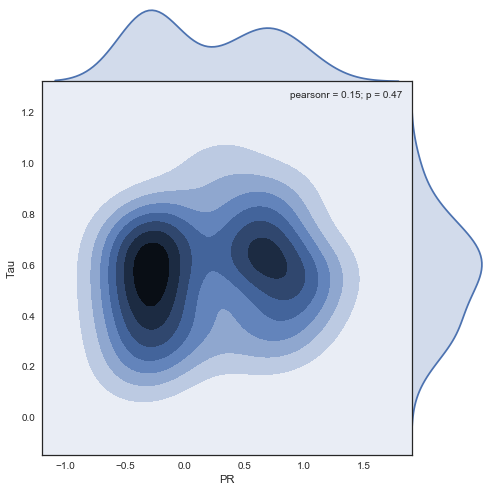

In [4]:
import pandas as pd
df=pd.DataFrame(dict(PR = PR, Tau = Tau))
import seaborn as sns
sns.set(style="white")
# g = sns.JointGrid()
g = sns.jointplot(x='PR', y='Tau',data=df, kind="kde", size=7, space=0)

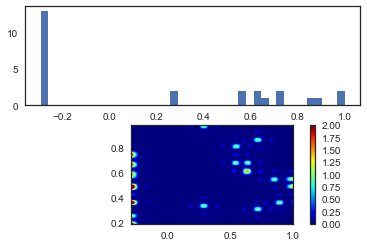

In [5]:
H, xedges, yedges = np.histogram2d(PR,Tau, bins=(30,30))
import matplotlib.cm as cm
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,1)
im=ax[1].imshow(H.transpose()[::-1], interpolation='sinc', \
                   cmap=cm.jet,extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]])
# ax[1].set_title(title)
fig.colorbar(im)                       

# import matplotlib.pyplot as plt
ax[0].hist(PR, bins=40) 
# plt.title(title)
plt.show()

In [6]:
time_bin_clk

32001.6